# Final Results

As last step we will evaluate final selected model Stratified Undersample Bagg + Boost (with best hyperparameters), on test data.

Additionally we will perform a small analaysis of feature importance.

In [3]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from toolkit import Viz, Tools, PF

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Pre configure modules
warnings.filterwarnings('ignore')
sns.set()
random_state = 42

In [4]:
# Function to reset data to original structures. With new features added. No transformations numeric features.
def reset_data():
    data, _, _, _ = PF.import_data()
    X, y = data[PF.cat_cols + PF.num_cols], data[PF.target_col]
    X = PF.add_features(X, y)
    X = PF.prepare_features(X, num_transform=False)

    strt = X[PF.strt_col]
    X.drop(PF.cntr_cols, axis=1, inplace=True)

    return data, X, y, strt

# Get Data, Separate Training and test datasets
data, X, y, strt = reset_data()

X_train, X_test, strt_train, strt_test = train_test_split(X, strt, test_size=.2, random_state=random_state)
y_train, y_test = y[X_train.index], y[X_test.index]

---
## Test Results

Note that for test results, we will reuse previous defined functions.

Additionaly a procedure was built to iterate over different threshold values to see how confusion matrix changes as threshold varies among high values.

In [5]:
# Get Stratified Bagg + Boost  Best Model
bbb = PF.best_strat_bagg_boost(X_train, strt_train)
strt_proba = bbb.predict_proba(X_test)
y_proba = list(map(lambda v: v[2], strt_proba))

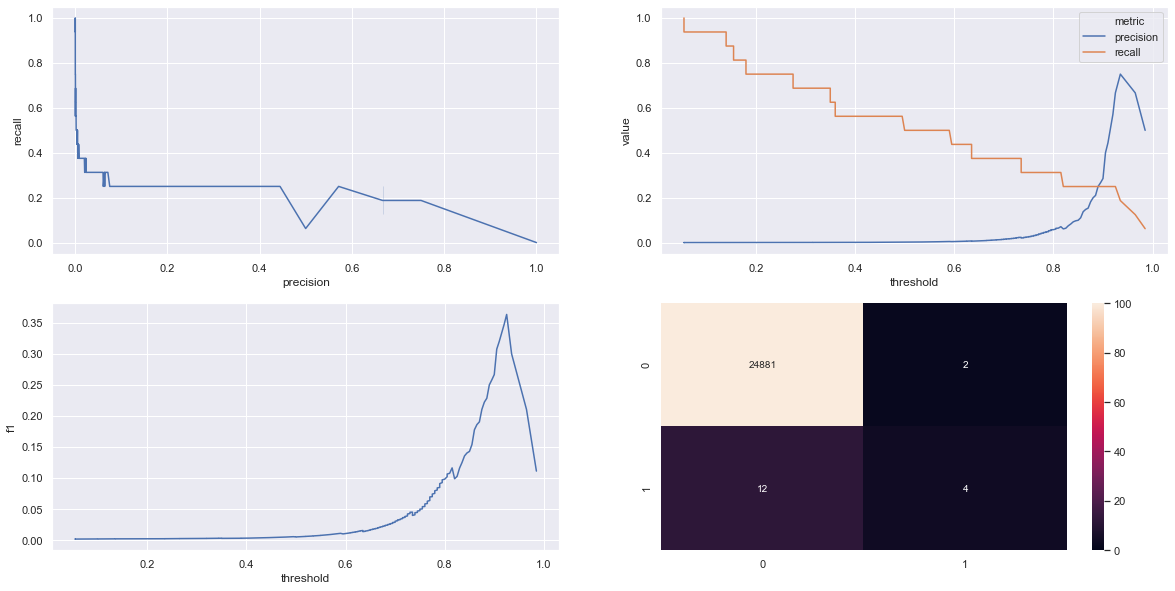

In [6]:
# Visualize results on test data 
bbb_mtrcs, bbb_thrsh, bbb_matrix = PF.get_metrics(y_test, y_proba, plot=True)

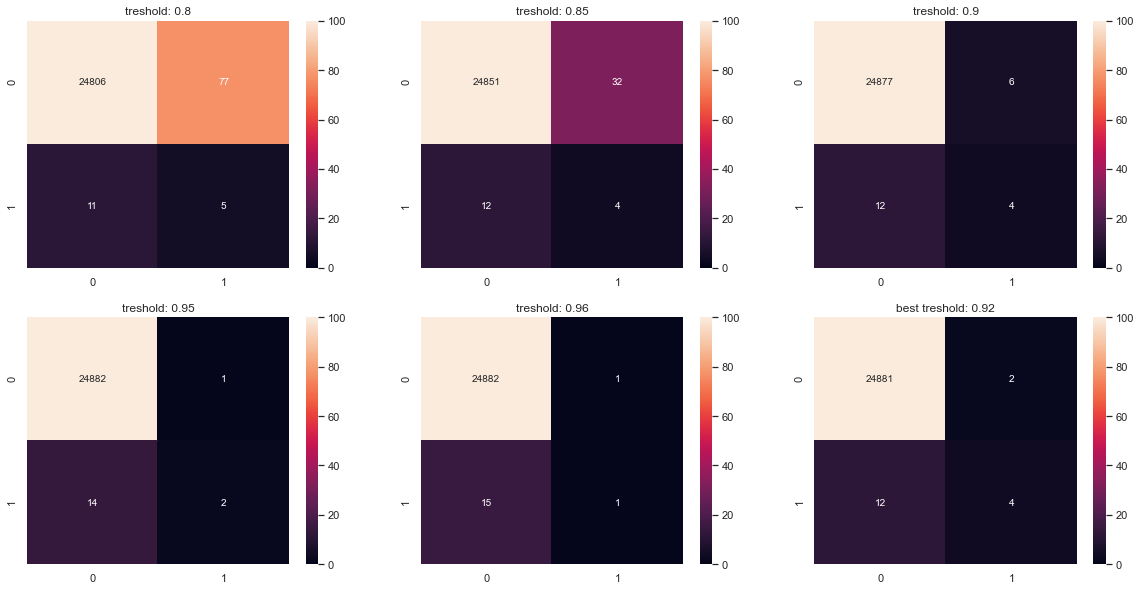

In [7]:
# Threshold values to iterate through
thresholds = [0.8, 0.85, 0.9, 0.95, 0.965, bbb_thrsh]

# Procedure to plot conusion matrixes per threshold
Viz.change_default(per_row=3)
ax = Viz.get_figure(6)

for i, t in enumerate(thresholds):
    y_pred = list(map(lambda v: 1 if v >= t else 0, y_proba))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, vmin= 0, vmax=100, square=False, annot=True, fmt='d', ax=ax[i])
    ax[i].set_title(f'treshold: {round(t, 2)}')
    if i == (len(thresholds) - 1): ax[i].set_title(f'best treshold: {round(t, 2)}')

Viz.change_default()
plt.show()

## Test Results - Conclusions
- As shown when tunning our models. It is much harder to reduce False Negatives.
- This is because of the high threshold that guarantees best False Positive and False Negative equilibrium.
- To make further improvements to model, it is important to get more information on the importance / impact of False Positives and False Negatives.
- If False Negatives are effectivelly more important. Score function can be modified to test if False Negative ratio improves.

---
## Feature Importance

A function `numeric_feature_importance()` was built as shown bellow, to give an idea of how important features really are to the model. It follows a iterative reduction approach. Where each numeric feature is removed (just one at a time) and F1, precision, recall and AUC scores will be calculated and stored. Confusion matrix values are stored as well if needed later.

In simple terms it evaluates how scores for the model will change when removing each of the numeric features.

Similarly to Random Search CV. Feature importance function can be time consuming (in a much less proportion but still). Because of this, it was already executed and result already stored in the **/output/feature_importance** folder.

A function to load this result will also be provided bellow.

In [8]:
# Function to compute scores when removing each numeric feature
def numeric_feature_importance(thrsh, save=True):   
    num_cols = PF.nnum_cols

    feature_scores = []
    for c in num_cols:
        Xsub_train, Xsub_test = X_train.drop(c, axis=1), X_test.drop(c, axis=1)
        bbb_sub = PF.best_strat_bagg_boost(Xsub_train, strt_train, trained=True)
        
        strt_sub_proba = bbb_sub.predict_proba(Xsub_test)
        y_sub_proba = list(map(lambda v: v[2], strt_sub_proba))
        y_sub_pred = list(map(lambda v: 1 if v >= thrsh else 0, y_sub_proba))

        f1 = f1_score(y_test, y_sub_pred)
        recall = recall_score(y_test, y_sub_pred)
        precision = precision_score(y_test, y_sub_pred)
        conf_matrix = confusion_matrix(y_test, y_sub_pred)
        TN, FP, FN, TP = conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]

        feature_scores.append({'col':c, 'f1':f1, 'recall':recall, 'precision':precision, 
                               'TN':TN, 'FP':FP, 'FN':FN, 'TP':TP})

    feature_scores = pd.DataFrame(feature_scores)

    if save: 
        current_time = datetime.now().strftime('%Y%m%d_%H%M')
        name = f'BBB_feature_scores_{current_time}'
        feature_scores.to_csv(f'output/feature_importance/{name}.csv')
    
    return feature_scores

# Undocument and execute if required
#feature_scores = numeric_feature_importance(bbb_thrsh, save=True)

In [9]:
# Function to load scores when removing each numeric feature
def load_num_feature_scores():
    file_path = 'output/feature_importance/BBB_feature_scores_20200322_0822.csv'
    feature_scores = pd.read_csv(file_path)
    feature_scores.drop(feature_scores.columns[0], axis=1, inplace=True)

    return feature_scores

# Load Feature Importance scores
feature_scores = load_num_feature_scores()

### Visualizing Feature Importance Results

The following procedure will help you visualize results For feature importance analysis.

The generated plot will show F1, Recall and Precision scores on 90% threshold for each submodel (when removing each numeric feature). Additionally scores obtained when using all features and best model will be added as benchmark (represented as dotted lines) to eassilly compare if improvementss where made or not.

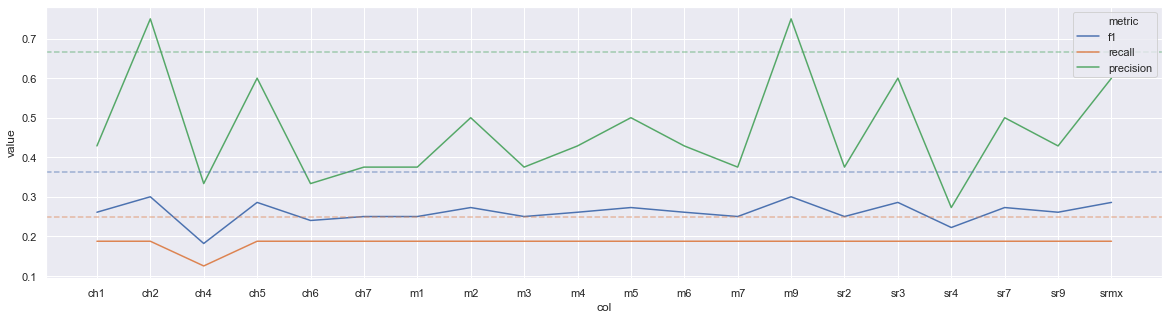

In [11]:
# Visualize how scores behave when removing numeric features
y_pred = list(map(lambda v: 1 if v >= bbb_thrsh else 0, y_proba))
b_f1, b_recall, b_prec = f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)

m_feature_scores = feature_scores.drop(['TN', 'FP', 'FN', 'TP'], axis=1)
m_feature_scores = m_feature_scores.melt(id_vars=['col'], var_name='metric')

ax, colors, alpha = Viz.get_figure(1), sns.color_palette(), 0.5
sns.lineplot(data=m_feature_scores, x='col', y='value', hue='metric', ax=ax)
ax.axhline(b_f1, ls='--', color=colors[0], alpha=alpha)
ax.axhline(b_recall, ls='--', color=colors[1], alpha=alpha)
ax.axhline(b_prec, ls='--', color=colors[2], alpha=alpha)
plt.show()

## Feature Importance - Conslusions
- It seems that all features add important information to the model
- Removing any numeric feature does not improve F1 score but in some cases may improve precision. Which itself does not need much improvement.
- Perhaps instead of removing existing columns, new ones could be added.